In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [2]:
df= pd.read_csv('https://raw.githubusercontent.com/dsrscientist/Dataset2/main/temperature.csv')
df

station        Date  Present_Tmax  Present_Tmin  LDAPS_RHmin  \
0         1.0  30-06-2013          28.7          21.4    58.255688   
1         2.0  30-06-2013          31.9          21.6    52.263397   
2         3.0  30-06-2013          31.6          23.3    48.690479   
3         4.0  30-06-2013          32.0          23.4    58.239788   
4         5.0  30-06-2013          31.4          21.9    56.174095   
...       ...         ...           ...           ...          ...   
7747     23.0  30-08-2017          23.3          17.1    26.741310   
7748     24.0  30-08-2017          23.3          17.7    24.040634   
7749     25.0  30-08-2017          23.2          17.4    22.933014   
7750      NaN         NaN          20.0          11.3    19.794666   
7751      NaN         NaN          37.6          29.9    98.524734   

      LDAPS_RHmax  LDAPS_Tmax_lapse  LDAPS_Tmin_lapse   LDAPS_WS    LDAPS_LH  \
0       91.116364         28.074101         23.006936   6.818887   69.451805   
1       90.604721         29.850689         24.035009   5.691890   51.937448   
2       83.973587         30.091292         24.565633   6.138224   20.573050   
3       96.483688         29.704629         23.326177   5.650050   65.727144   
4       90.155128         29.113934         23.486480   5.735004  107.965535   
...           ...               ...               ...        ...         ...   
7747    78.869858         26.352081         18.775678   6.148918   72.058294   
7748    77.294975         27.010193         18.733519   6.542819   47.241457   
7749    77.243744         27.939516         18.522965   7.289264    9.090034   
7750    58.936283         17.624954         14.272646   2.882580  -13.603212   
7751   100.000153         38.542255         29.619342  21.857621  213.414006   

      ...  LDAPS_PPT2  LDAPS_PPT3  LDAPS_PPT4      lat      lon       DEM  \
0     ...    0.000000    0.000000    0.000000  37.6046  126.991  212.3350   
1     ...    0.000000    0.000000    0.000000  37.6046  127.032   44.7624   
2     ...    0.000000    0.000000    0.000000  37.5776  127.058   33.3068   
3     ...    0.000000    0.000000    0.000000  37.6450  127.022   45.7160   
4     ...    0.000000    0.000000    0.000000  37.5507  127.135   35.0380   
...   ...         ...         ...         ...      ...      ...       ...   
7747  ...    0.000000    0.000000    0.000000  37.5372  126.891   15.5876   
7748  ...    0.000000    0.000000    0.000000  37.5237  126.909   17.2956   
7749  ...    0.000000    0.000000    0.000000  37.5237  126.970   19.5844   
7750  ...    0.000000    0.000000    0.000000  37.4562  126.826   12.3700   
7751  ...   21.621661   15.841235   16.655469  37.6450  127.135  212.3350   

         Slope  Solar radiation  Next_Tmax  Next_Tmin  
0     2.785000      5992.895996       29.1       21.2  
1     0.514100      5869.312500       30.5       22.5  
2     0.266100      5863.555664       31.1       23.9  
3     2.534800      5856.964844       31.7       24.3  
4     0.505500      5859.552246       31.2       22.5  
...        ...              ...        ...        ...  
7747  0.155400      4443.313965       28.3       18.1  
7748  0.222300      4438.373535       28.6       18.8  
7749  0.271300      4451.345215       27.8       17.4  
7750  0.098475      4329.520508       17.4       11.3  
7751  5.178230      5992.895996       38.9       29.8  

[7752 rows x 25 columns]

In [3]:
df.dropna(inplace=True)

In [4]:
df.isnull().sum()

station             0
Date                0
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
lat                 0
lon                 0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7588 entries, 0 to 7749
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   station           7588 non-null   float64
 1   Date              7588 non-null   object 
 2   Present_Tmax      7588 non-null   float64
 3   Present_Tmin      7588 non-null   float64
 4   LDAPS_RHmin       7588 non-null   float64
 5   LDAPS_RHmax       7588 non-null   float64
 6   LDAPS_Tmax_lapse  7588 non-null   float64
 7   LDAPS_Tmin_lapse  7588 non-null   float64
 8   LDAPS_WS          7588 non-null   float64
 9   LDAPS_LH          7588 non-null   float64
 10  LDAPS_CC1         7588 non-null   float64
 11  LDAPS_CC2         7588 non-null   float64
 12  LDAPS_CC3         7588 non-null   float64
 13  LDAPS_CC4         7588 non-null   float64
 14  LDAPS_PPT1        7588 non-null   float64
 15  LDAPS_PPT2        7588 non-null   float64
 16  LDAPS_PPT3        7588 non-null   float64


In [6]:
df.Next_Tmin.unique()

array([21.2, 22.5, 23.9, 24.3, 24. , 23.4, 22.9, 21.6, 21. , 24.5, 22.2,
       22.8, 20.9, 21.1, 23. , 23.7, 23.2, 24.2, 18.7, 21.5, 21.8, 22.3,
       21.3, 20.7, 19.8, 20.8, 21.7, 22.1, 20.5, 21.9, 17.8, 20.1, 20.3,
       19.4, 19.1, 18.9, 20. , 19.7, 19.5, 20.6, 23.1, 23.3, 22.7, 22.6,
       22.4, 22. , 23.5, 23.8, 21.4, 19.3, 20.4, 19.9, 20.2, 24.1, 23.6,
       24.4, 24.8, 25.1, 24.6, 24.7, 25. , 24.9, 25.3, 26. , 26.1, 25.5,
       25.8, 25.4, 25.6, 25.7, 25.2, 25.9, 26.3, 26.2, 26.4, 26.5, 26.9,
       26.8, 26.6, 27. , 27.1, 26.7, 27.5, 27.2, 27.4, 27.7, 28.3, 27.6,
       28. , 27.3, 19.6, 19.2, 18.6, 18.5, 18.2, 18.4, 18.8, 17.9, 17.5,
       16.5, 18. , 19. , 16.7, 18.1, 18.3, 28.1, 28.4, 29.4, 29.1, 28.5,
       28.8, 29.8, 29.5, 28.6, 17.1, 16.8, 17.6, 17.4, 15.8, 16.9, 17.7,
       17.2, 15.5, 16.6, 16.4, 16.3, 17. , 14.7, 15.9, 16. , 17.3, 15.4,
       15.3, 13.8, 15.6, 15.1, 27.9, 28.7, 27.8, 28.2, 13.3, 14.1, 15. ,
       11.3, 13.4, 15.7, 14.9, 16.2, 14.4, 16.1, 29

In [7]:
df.Next_Tmax.value_counts()

29.3    113
33.0    104
31.3    100
29.6     98
31.2     97
       ... 
17.4      1
20.9      1
18.9      1
18.6      1
19.7      1
Name: Next_Tmax, Length: 181, dtype: int64

In [8]:
df.Next_Tmin.value_counts()

23.5    157
24.0    152
23.4    150
23.2    148
23.8    146
       ... 
29.4      1
11.3      1
12.9      1
13.6      1
29.8      1
Name: Next_Tmin, Length: 157, dtype: int64

In [9]:
df.dtypes

station             float64
Date                 object
Present_Tmax        float64
Present_Tmin        float64
LDAPS_RHmin         float64
LDAPS_RHmax         float64
LDAPS_Tmax_lapse    float64
LDAPS_Tmin_lapse    float64
LDAPS_WS            float64
LDAPS_LH            float64
LDAPS_CC1           float64
LDAPS_CC2           float64
LDAPS_CC3           float64
LDAPS_CC4           float64
LDAPS_PPT1          float64
LDAPS_PPT2          float64
LDAPS_PPT3          float64
LDAPS_PPT4          float64
lat                 float64
lon                 float64
DEM                 float64
Slope               float64
Solar radiation     float64
Next_Tmax           float64
Next_Tmin           float64
dtype: object

In [10]:
df.columns

Index(['station', 'Date', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin',
       'LDAPS_RHmax', 'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS',
       'LDAPS_LH', 'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4',
       'LDAPS_PPT1', 'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon',
       'DEM', 'Slope', 'Solar radiation', 'Next_Tmax', 'Next_Tmin'],
      dtype='object')

In [11]:
df.describe()

station  Present_Tmax  Present_Tmin  LDAPS_RHmin  LDAPS_RHmax  \
count  7588.000000   7588.000000   7588.000000  7588.000000  7588.000000   
mean     13.014101     29.748366     23.195809    56.724969    88.360823   
std       7.217858      2.967401      2.400880    14.626559     7.199456   
min       1.000000     20.000000     11.300000    19.794666    58.936283   
25%       7.000000     27.800000     21.600000    45.960243    84.203724   
50%      13.000000     29.900000     23.400000    55.023199    89.784122   
75%      19.000000     32.000000     24.800000    67.115099    93.742725   
max      25.000000     37.600000     29.900000    98.524734   100.000153   

       LDAPS_Tmax_lapse  LDAPS_Tmin_lapse     LDAPS_WS     LDAPS_LH  \
count       7588.000000       7588.000000  7588.000000  7588.000000   
mean          29.620128         23.511786     7.094097    62.492606   
std            2.943496          2.342579     2.177034    33.686158   
min           17.624954         14.272646     2.882580   -13.603212   
25%           27.673756         22.086820     5.675358    37.206201   
50%           29.709537         23.758249     6.547838    56.898324   
75%           31.711109         25.155660     8.028960    84.235666   
max           38.542255         29.619342    21.857621   213.414006   

         LDAPS_CC1  ...   LDAPS_PPT2   LDAPS_PPT3   LDAPS_PPT4          lat  \
count  7588.000000  ...  7588.000000  7588.000000  7588.000000  7588.000000   
mean      0.368510  ...     0.480738     0.275007     0.265373    37.544792   
std       0.262260  ...     1.743327     1.146087     1.179661     0.050428   
min       0.000000  ...     0.000000     0.000000     0.000000    37.456200   
25%       0.146546  ...     0.000000     0.000000     0.000000    37.510200   
50%       0.315706  ...     0.000000     0.000000     0.000000    37.550700   
75%       0.574174  ...     0.017735     0.007855     0.000017    37.577600   
max       0.967277  ...    21.621661    15.841235    16.655469    37.645000   

              lon          DEM        Slope  Solar radiation    Next_Tmax  \
count  7588.00000  7588.000000  7588.000000      7588.000000  7588.000000   
mean    126.99142    61.918136     1.259755      5343.724208    30.241526   
std       0.07922    54.323529     1.372748       429.782561     3.111807   
min     126.82600    12.370000     0.098500      4329.520508    17.400000   
25%     126.93700    28.700000     0.271300      5001.485717    28.200000   
50%     126.99500    45.716000     0.618000      5441.987305    30.400000   
75%     127.04200    59.832400     1.767800      5729.485840    32.600000   
max     127.13500   212.335000     5.178200      5992.895996    38.900000   

         Next_Tmin  
count  7588.000000  
mean     22.910820  
std       2.482256  
min      11.300000  
25%      21.300000  
50%      23.100000  
75%      24.600000  
max      29.800000  

[8 rows x 24 columns]

Univariate analysis

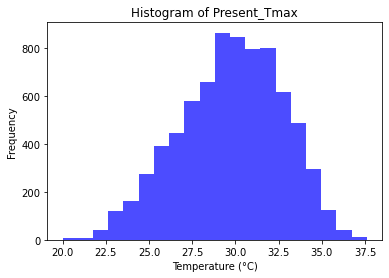

In [12]:
plt.hist(df['Present_Tmax'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Present_Tmax')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

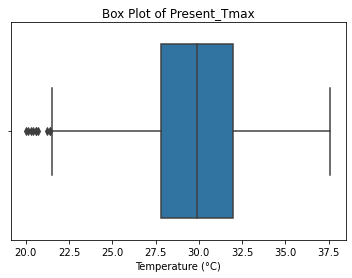

In [13]:
sns.boxplot(x=df['Present_Tmax'])
plt.title('Box Plot of Present_Tmax')
plt.xlabel('Temperature (°C)')
plt.show()

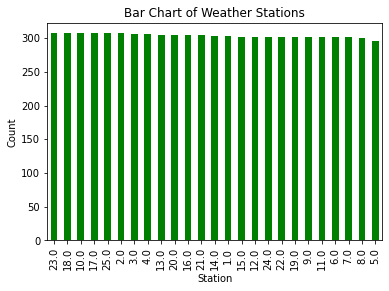

In [14]:
df['station'].value_counts().plot(kind='bar', color='green')
plt.title('Bar Chart of Weather Stations')
plt.xlabel('Station')
plt.ylabel('Count')
plt.show()

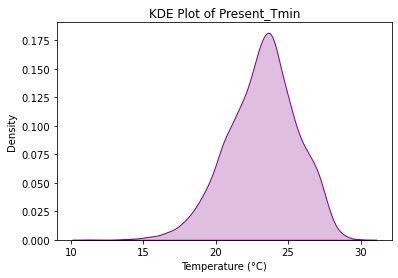

In [15]:
sns.kdeplot(df['Present_Tmin'], fill=True, color='purple')
plt.title('KDE Plot of Present_Tmin')
plt.xlabel('Temperature (°C)')
plt.ylabel('Density')
plt.show()

Bivariate analysis

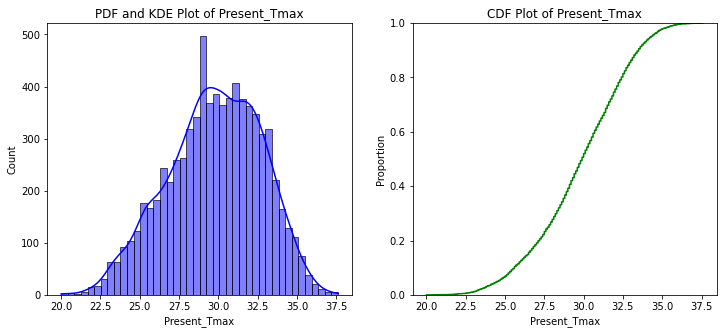

In [16]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['Present_Tmax'], kde=True, color='blue')
plt.title('PDF and KDE Plot of Present_Tmax')

plt.subplot(1, 2, 2)
sns.ecdfplot(df['Present_Tmax'], color='green')
plt.title('CDF Plot of Present_Tmax')

plt.show()

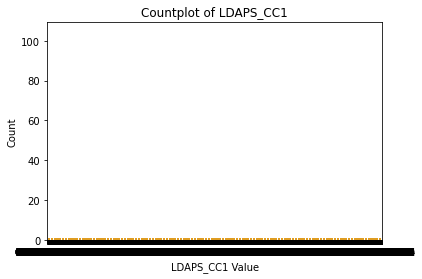

In [17]:
sns.countplot(x=df['LDAPS_CC1'], color='orange')
plt.title('Countplot of LDAPS_CC1')
plt.xlabel('LDAPS_CC1 Value')
plt.ylabel('Count')
plt.show()

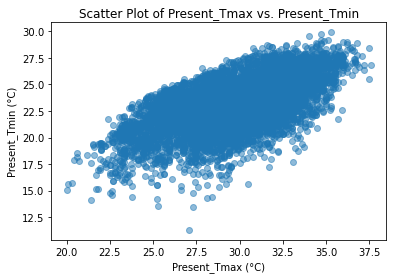

In [18]:
plt.scatter(df['Present_Tmax'], df['Present_Tmin'], alpha=0.5)
plt.title('Scatter Plot of Present_Tmax vs. Present_Tmin')
plt.xlabel('Present_Tmax (°C)')
plt.ylabel('Present_Tmin (°C)')
plt.show()

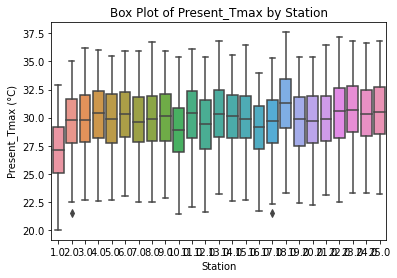

In [19]:
sns.boxplot(x=df['station'], y=df['Present_Tmax'])
plt.title('Box Plot of Present_Tmax by Station')
plt.xlabel('Station')
plt.ylabel('Present_Tmax (°C)')
plt.show()

In [20]:
import plotly.express as px

fig = px.scatter(df, x='Present_Tmax', y='Present_Tmin', title='Scatter Plot of Present_Tmax vs. Present_Tmin')
fig.update_xaxes(title_text='Present_Tmax (°C)')
fig.update_yaxes(title_text='Present_Tmin (°C)')

fig.show()

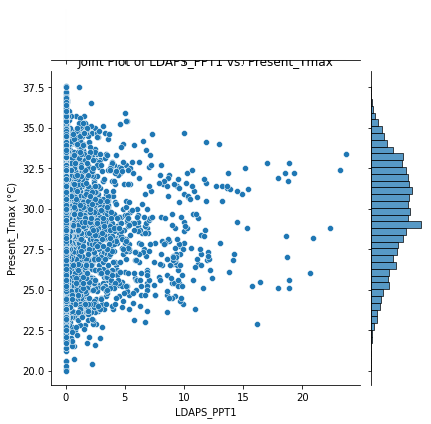

In [21]:
sns.jointplot(x=df['LDAPS_PPT1'], y=df['Present_Tmax'], kind='scatter')
plt.title('Joint Plot of LDAPS_PPT1 vs. Present_Tmax')
plt.xlabel('LDAPS_PPT1')
plt.ylabel('Present_Tmax (°C)')
plt.show()

In [22]:
fig = px.scatter(df, x='Present_Tmax', y='Present_Tmin', title='Joint Plot of Present_Tmax vs. Present_Tmin',
                 marginal_x='histogram', marginal_y='histogram')
fig.update_xaxes(title_text='Present_Tmax (°C)')
fig.update_yaxes(title_text='Present_Tmin (°C)')

fig.show()

Multivariate Analysis

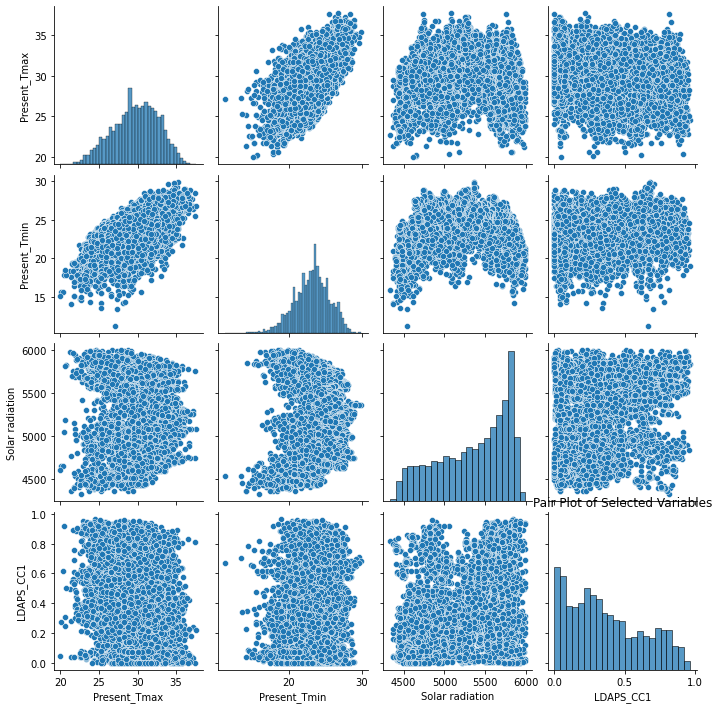

In [23]:
sns.pairplot(df[['Present_Tmax', 'Present_Tmin', 'Solar radiation', 'LDAPS_CC1']])
plt.title('Pair Plot of Selected Variables')
plt.show()

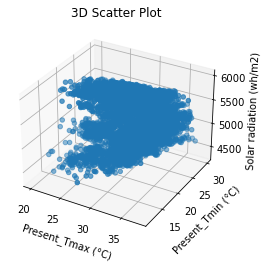

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Present_Tmax'], df['Present_Tmin'], df['Solar radiation'])
ax.set_xlabel('Present_Tmax (°C)')
ax.set_ylabel('Present_Tmin (°C)')
ax.set_zlabel('Solar radiation (wh/m2)')
plt.title('3D Scatter Plot')
plt.show()

In [25]:
correlation=df.corr()
correlation

station  Present_Tmax  Present_Tmin  LDAPS_RHmin  \
station           1.000000      0.113301      0.133282    -0.067846   
Present_Tmax      0.113301      1.000000      0.615208    -0.209059   
Present_Tmin      0.133282      0.615208      1.000000     0.122200   
LDAPS_RHmin      -0.067846     -0.209059      0.122200     1.000000   
LDAPS_RHmax      -0.169351     -0.306943     -0.018576     0.578358   
LDAPS_Tmax_lapse  0.069856      0.573777      0.467904    -0.569580   
LDAPS_Tmin_lapse  0.105277      0.628705      0.772061     0.085237   
LDAPS_WS          0.005822     -0.125952     -0.038779     0.289422   
LDAPS_LH         -0.132129      0.134246     -0.012817    -0.072195   
LDAPS_CC1         0.006539     -0.316333      0.084348     0.612831   
LDAPS_CC2         0.003526     -0.216976      0.090038     0.744774   
LDAPS_CC3        -0.000161     -0.146391     -0.004719     0.688069   
LDAPS_CC4         0.005005     -0.143069     -0.046694     0.513937   
LDAPS_PPT1       -0.001954     -0.114917      0.111577     0.259039   
LDAPS_PPT2       -0.007635     -0.104779      0.066207     0.389572   
LDAPS_PPT3       -0.013865     -0.127248     -0.052428     0.237512   
LDAPS_PPT4       -0.011085     -0.107295     -0.070391     0.167311   
lat              -0.239118     -0.054134     -0.081417     0.085027   
lon              -0.118845      0.007695     -0.045174    -0.077590   
DEM              -0.256706     -0.189439     -0.254084     0.100684   
Slope            -0.091721     -0.107079     -0.148423     0.122454   
Solar radiation  -0.021194     -0.022114      0.059765     0.242168   
Next_Tmax         0.107747      0.610357      0.463523    -0.446824   
Next_Tmin         0.128184      0.621048      0.796975     0.093249   

                  LDAPS_RHmax  LDAPS_Tmax_lapse  LDAPS_Tmin_lapse  LDAPS_WS  \
station             -0.169351          0.069856          0.105277  0.005822   
Present_Tmax        -0.306943          0.573777          0.628705 -0.125952   
Present_Tmin        -0.018576          0.467904          0.772061 -0.038779   
LDAPS_RHmin          0.578358         -0.569580          0.085237  0.289422   
LDAPS_RHmax          1.000000         -0.377293         -0.118965  0.131269   
LDAPS_Tmax_lapse    -0.377293          1.000000          0.653425 -0.316011   
LDAPS_Tmin_lapse    -0.118965          0.653425          1.000000 -0.134652   
LDAPS_WS             0.131269         -0.316011         -0.134652  1.000000   
LDAPS_LH             0.238986          0.043663         -0.139675  0.004427   
LDAPS_CC1            0.435937         -0.440878          0.008714  0.285349   
LDAPS_CC2            0.390620         -0.525380          0.046537  0.257226   
LDAPS_CC3            0.224734         -0.542728         -0.044998  0.238155   
LDAPS_CC4            0.127242         -0.429739         -0.079536  0.218870   
LDAPS_PPT1           0.268019         -0.115659          0.034956  0.141503   
LDAPS_PPT2           0.227581         -0.248369         -0.002743  0.181634   
LDAPS_PPT3           0.132436         -0.193749         -0.093116  0.147199   
LDAPS_PPT4           0.118101         -0.170415         -0.103541  0.134428   
lat                  0.194820         -0.044052         -0.099452  0.033025   
lon                  0.025563          0.091568         -0.024703 -0.063009   
DEM                  0.176557         -0.181433         -0.198396  0.188540   
Slope                0.219436         -0.163891         -0.187864  0.169223   
Solar radiation      0.146622          0.047414          0.157763  0.120630   
Next_Tmax           -0.289788          0.835729          0.592119 -0.351107   
Next_Tmin           -0.076415          0.589963          0.886513 -0.102021   

                  LDAPS_LH  LDAPS_CC1  ...  LDAPS_PPT2  LDAPS_PPT3  \
station          -0.132129   0.006539  ...   -0.007635   -0.013865   
Present_Tmax      0.134246  -0.316333  ...   -0.104779   -0.127248   
Present_Tmin     -0.012817   0.084348  ...    0.066207   

<AxesSubplot:>

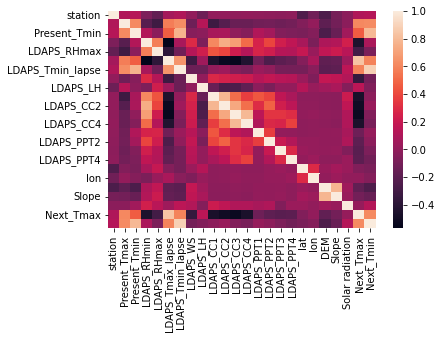

In [26]:
sns.heatmap(correlation)

<AxesSubplot:>

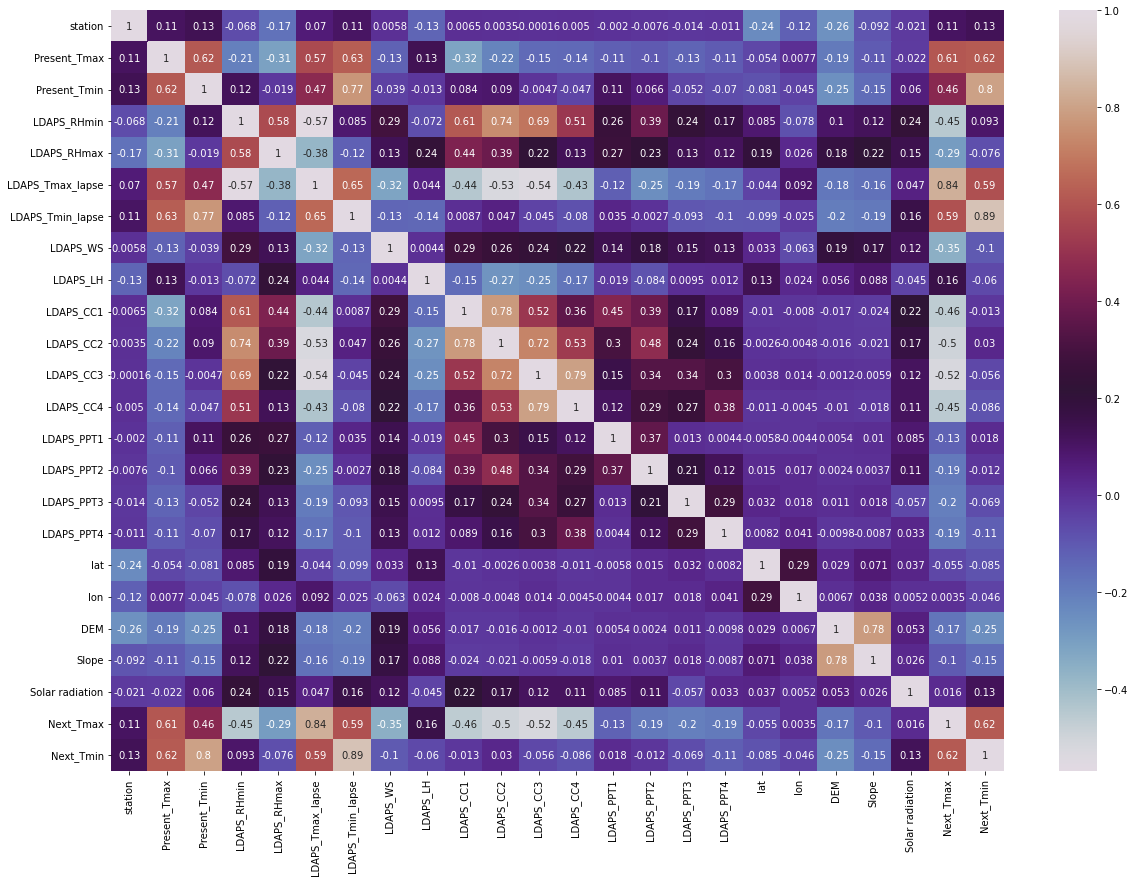

In [27]:
plt.figure(figsize=(20,14))
sns.heatmap(correlation,cmap='twilight',annot=True)

Skewness

In [28]:
numerical_columns = df.select_dtypes(include=[float, int]).columns

skewness_results = {}
for column in numerical_columns:
    skewness = df[column].skew()
    skewness_results[column] = skewness


skewness_df = pd.DataFrame(skewness_results, index=['Skewness']).T

print(skewness_df)

                  Skewness
station          -0.004178
Present_Tmax     -0.257069
Present_Tmin     -0.353822
LDAPS_RHmin       0.301396
LDAPS_RHmax      -0.845264
LDAPS_Tmax_lapse -0.222349
LDAPS_Tmin_lapse -0.574035
LDAPS_WS          1.553926
LDAPS_LH          0.662971
LDAPS_CC1         0.456716
LDAPS_CC2         0.473929
LDAPS_CC3         0.639649
LDAPS_CC4         0.663815
LDAPS_PPT1        5.305906
LDAPS_PPT2        5.710360
LDAPS_PPT3        6.356670
LDAPS_PPT4        6.681256
lat               0.085377
lon              -0.289048
DEM               1.721617
Slope             1.559050
Solar radiation  -0.524325
Next_Tmax        -0.334842
Next_Tmin        -0.393662


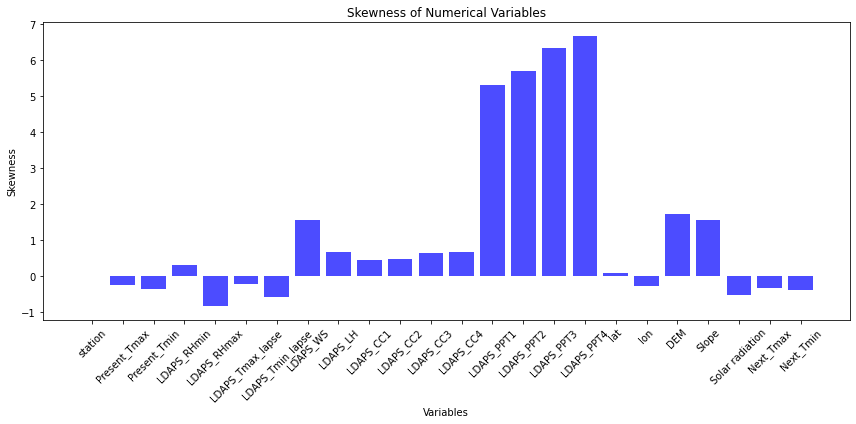

In [29]:
numerical_columns = df.select_dtypes(include=[float, int]).columns

skewness_results = {}
for column in numerical_columns:
    skewness = df[column].skew()
    skewness_results[column] = skewness

skewness_df = pd.DataFrame(skewness_results, index=['Skewness']).T


plt.figure(figsize=(12, 6))
plt.bar(skewness_df.index, skewness_df['Skewness'], color='blue', alpha=0.7)
plt.title('Skewness of Numerical Variables')
plt.xlabel('Variables')
plt.ylabel('Skewness')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
numerical_columns = df.select_dtypes(include=[float, int]).columns


outliers_info = {}

for column in numerical_columns:

    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    
    potential_outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    
    outliers_info[column] = {
        'Lower Bound': lower_bound,
        'Upper Bound': upper_bound,
        'Number of Outliers': len(potential_outliers),
        'Outlier Indices': potential_outliers.index.tolist()
    }

outliers_df = pd.DataFrame(outliers_info)


print(outliers_df)

                   station                                       Present_Tmax  \
Lower Bound          -11.0                                               21.5   
Upper Bound           37.0                                               38.3   
Number of Outliers       0                                                 10   
Outlier Indices         []  [1625, 2675, 2775, 4525, 5050, 5075, 6125, 770...   

                                                         Present_Tmin  \
Lower Bound                                                      16.8   
Upper Bound                                                      29.6   
Number of Outliers                                                 72   
Outlier Indices     [2150, 2161, 2397, 2398, 2601, 2616, 3041, 317...   

                   LDAPS_RHmin  \
Lower Bound           14.22796   
Upper Bound          98.847383   
Number of Outliers           0   
Outlier Indices             []   

                                                         

As we can see that our dataset has outliers and we need apply data preprocessing to address and remove the outliers.

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [32]:
X = df.drop(['Next_Tmax', 'Next_Tmin'], axis=1)
y_next_tmax = df['Next_Tmax']
y_next_tmin = df['Next_Tmin']

In [33]:
X_train, X_test, y_next_tmax_train, y_next_tmax_test, y_next_tmin_train, y_next_tmin_test = train_test_split(
    X, y_next_tmax, y_next_tmin, test_size=0.2, random_state=42)

In [34]:
numerical_features = X.select_dtypes(include=['float', 'int']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [35]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

In [36]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [37]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [38]:
from sklearn.linear_model import LinearRegression

model_next_tmax = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', LinearRegression())])

model_next_tmin = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', LinearRegression())])

In [39]:
model_next_tmax.fit(X_train, y_next_tmax_train)
model_next_tmin.fit(X_train, y_next_tmin_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['station', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax',
       'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
       'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1',
       'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon', 'DEM', 'Slope',
       'Solar radiation'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                            

In [40]:
next_tmax_test_predictions = model_next_tmax.predict(X_test)
next_tmin_test_predictions = model_next_tmin.predict(X_test)

In [41]:
print(next_tmax_test_predictions)
print(next_tmin_test_predictions)

[29.16251531 27.93571438 33.44808442 ... 30.32290141 22.98051832
 26.14467912]
[25.41839807 22.04807593 24.00458123 ... 20.90061082 19.39052535
 21.33993038]


In [42]:
def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [43]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [44]:
y = y_next_tmax_train
print(y.shape)
ydf=pd.DataFrame(y)
ydf

(6070,)


Next_Tmax
6642       31.9
7469       25.3
6936       32.6
2357       35.3
350        26.1
...         ...
5253       31.9
5288       31.8
5477       34.1
868        31.3
7419       29.6

[6070 rows x 1 columns]

In [45]:
df.isnull().sum()

station             0
Date                0
Present_Tmax        0
Present_Tmin        0
LDAPS_RHmin         0
LDAPS_RHmax         0
LDAPS_Tmax_lapse    0
LDAPS_Tmin_lapse    0
LDAPS_WS            0
LDAPS_LH            0
LDAPS_CC1           0
LDAPS_CC2           0
LDAPS_CC3           0
LDAPS_CC4           0
LDAPS_PPT1          0
LDAPS_PPT2          0
LDAPS_PPT3          0
LDAPS_PPT4          0
lat                 0
lon                 0
DEM                 0
Slope               0
Solar radiation     0
Next_Tmax           0
Next_Tmin           0
dtype: int64

In [48]:
from sklearn import preprocessing 
le=preprocessing.LabelEncoder()

In [49]:
df['Date']=le.fit_transform(df['Date'])

In [50]:
from scipy.stats import zscore
z=np.abs(zscore(df))
z

array([[1.66460654, 1.52443424, 0.35331763, ..., 1.51056517, 0.36686121,
        0.68926525],
       [1.52605214, 1.52443424, 0.72513836, ..., 1.22299734, 0.08306779,
        0.1655135 ],
       [1.38749775, 1.52443424, 0.62403311, ..., 1.20960169, 0.27589451,
        0.39852685],
       ...,
       [1.38359018, 1.68249023, 2.17321212, ..., 2.09517477, 0.6239635 ,
        1.93821173],
       [1.52214457, 1.68249023, 2.17321212, ..., 2.10667071, 0.52755014,
        1.65619156],
       [1.66069897, 1.68249023, 2.20691387, ..., 2.07648676, 0.78465243,
        2.2202319 ]])

In [51]:
threshold=3
print(np.where(z>3))

(array([  25,   25,   26, ..., 7581, 7582, 7582], dtype=int64), array([ 8, 15, 15, ...,  3,  3,  7], dtype=int64))


In [52]:
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [61]:
from sklearn.model_selection import cross_val_score
model = RandomForestRegressor(n_estimators=100, random_state=42)

try:
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    # Replace X and y with your feature matrix and target variable

    # Calculate the root mean squared error (RMSE) from the negative mean squared error scores
    rmse_scores = (-cv_scores) ** 0.5

    # Print the RMSE scores for each fold
    print("RMSE Scores:", rmse_scores)
    mean_rmse = rmse_scores.mean()
    print("Mean RMSE:", mean_rmse)
except ValueError as e:
    print("ValueError:", e)

ValueError: Found input variables with inconsistent numbers of samples: [7588, 6070]
